In [1]:
!pip install ISLP

  Using cached ISLP-0.4.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached lifelines-0.29.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached pygam-0.9.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached torch-2.4.1-cp311-cp311-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached pytorch_lightning-2.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached torchmetrics-1.4.2-py3-none-any.whl.metadata (19 kB)
  Using cached autograd-1.7.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached autograd_gamma-0.5.0-py3-none-any.whl
  Using cached formulaic-1.0.2-py3-none-any.whl.metadata (6.8 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached progressbar2-4.5.0-py3-none-any.whl.metadata (16 kB)
  Using cached lightning_utilities-0.11.7-py3-none-any.whl.metadata (5.2 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-many

Using cached ISLP-0.4.0-py3-none-any.whl (3.6 MB)
Using cached lifelines-0.29.0-py3-none-any.whl (349 kB)
Using cached pygam-0.9.1-py3-none-any.whl (522 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached pytorch_lightning-2.4.0-py3-none-any.whl (815 kB)
Using cached torch-2.4.1-cp311-cp311-manylinux1_x86_64.whl (797.1 MB)
Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
Using cached nvidia_c

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler 
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.pipeline import Pipeline
from ISLP.models import \
(Stepwise , sklearn_selected , sklearn_selection_path)
import warnings
warnings.filterwarnings('ignore')

## Ridge Regression and the Lasso (Lab 6.5.2 in the Textbook)

Let's use the `sklearn.linear_model` to fit ridge and lasso regularized linear models. For that we use the `Hitters` dataset, aiming to predict the salary of a baseball player based on their performance in the previous year. We start by loading the data and building our response vector and design matrix (without intercept):

In [3]:
Hitters = load_data('Hitters')
# drop players with missing salaries
Hitters = Hitters.dropna() 

design = MS(Hitters.columns.drop('Salary')).fit(Hitters) 
Y = np.array(Hitters['Salary'])
D = design.fit_transform(Hitters)
# drop the intercept
D = D.drop('intercept', axis=1)
X = np.asarray(D)

We begin by standardizing the columns of X, to prevent any effect from the variables different units. Then we use `skl.ElasticNet.path()` to fit a ridge regression (setting `l1_ratio=0`). We use a grid of 100 values of $\lambda$, ranging from $\lambda=10^8$ to $\lambda=10^{-2}$, scaled by the standard deviation of $y$. Associated with each value of $\lambda$ there is a vector of ridge regression coefficients, corresponding to a column of `soln_array`. As shown below, `soln_array` is a 19 × 100 matrix, with 19 rows (one for each predictor) and 100 columns (one for each value of $\lambda$).

In [4]:
# standarize each column
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]

# create grid of penalties and fit ridge
lambdas = 10**np.linspace(8, -2, 100) / Y.std() 
soln_array = skl.ElasticNet.path(Xs, Y, l1_ratio = 0., alphas=lambdas)[1]

In [5]:
soln_array.shape

(19, 100)

Let's give do some formatting to our estimates array:

In [6]:
soln_path = pd.DataFrame(soln_array.T, columns = D.columns, index = np.log(lambdas)) 
soln_path.index.name = 'log(lambda)'
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
log(lambda),,,,,,,,,,,,,,,,,,,
12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
-10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
-10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


Below, we plot the estimated coefficients for each value of (log)$\lambda$. In the plot we can clearly see that, as the penalty increases, all coefficients shrink closer to zero. 

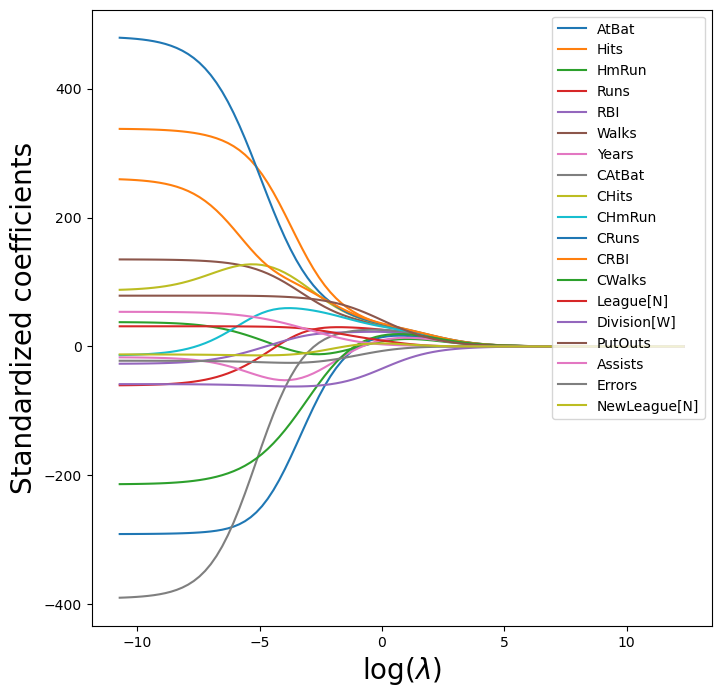

In [7]:
path_fig, ax = subplots(figsize = (8,8)) 
soln_path.plot(ax = ax, legend = False) 
ax.set_xlabel('$\log(\lambda)$', fontsize = 20)
ax.set_ylabel('Standardized coefficients', fontsize = 20) 
ax.legend(loc = 'upper right')

Below we can see the coefficients estimated using the 50th penalty value, $\lambda = 2.4948$.

In [8]:
beta_hat = soln_path.loc[soln_path.index[49]] 
lambdas[49], beta_hat

(2.494832928915928,
 AtBat           16.568156
 Hits            24.853040
 HmRun           11.483941
 Runs            21.255881
 RBI             20.319885
 Walks           24.533865
 Years           13.455098
 CAtBat          22.853088
 CHits           26.455612
 CHmRun          24.513016
 CRuns           27.068870
 CRBI            27.459130
 CWalks          18.999006
 League[N]        4.607921
 Division[W]    -20.563826
 PutOuts         25.719223
 Assists          1.747392
 Errors          -2.828710
 NewLeague[N]     3.357502
 Name: 0.9142217646030576, dtype: float64)

The $\ell_2$ associate with these value of $\lambda$ is:

In [9]:
np.linalg.norm(beta_hat)

86.43129987265401

If we consider the 60th value, $\lambda = 0.2437$, we get:

In [10]:
beta_hat = soln_path.loc[soln_path.index[59]] 
lambdas[59], np.linalg.norm(beta_hat)

(0.2437476613348855, 160.4237101772597)

Note that as $\lambda$ decreases the associated $\ell_2$ norm increases. 

### Using Pipeline Objects

Above, we manually normalized the design matrix. Through `Pipeline()` objects and the `StandardScaler()` function, `sklearn` provides a way to easily carry out the process. Let's give it a try using the 60th $\lambda$:

In [11]:
ridge = skl.ElasticNet(alpha = lambdas[59], l1_ratio = 0)
scaler = StandardScaler(with_mean = True, with_std = True)
# create a pipeline where we scale first, and then fit a ridge regression
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)]) 
# apply the pipeline to our data
pipe.fit(X, Y)
np.linalg.norm(ridge.coef_)

160.423710177259

`pipe.fit()` changes the `ridge` object, and adds attributes such as `coef_`. Note that the resulting $\ell_2$ norm is the same as before.

### Ridge Regression Test Error

The `ridge` object modified with `Pipeline()` can be used in `cross_validate()` to choose the best $\lambda$ value:

In [12]:
# create a fixed random split (for reproducibility)
validation = skm.ShuffleSplit(n_splits = 1, test_size=0.5, random_state = 0) 

ridge.alpha = 0.01
results = skm.cross_validate(
    ridge,  
    X,
    Y,
    scoring = 'neg_mean_squared_error', # if not specified, R^2 is used
    cv = validation # validation method is used (single split)
)
-results['test_score']


array([134214.00419204])

The test MSE estimated using the validation method for $\lambda = 0.01$ is shown above. We can use `GridSearchCV()` and perform 5-fold cross-validation on a grid of values to identify the optimal (in terms of the cross-validated MSE) $\lambda$ to use.

In [13]:
K = 5 # 5 random folds
kfold = skm.KFold(
    K, 
    random_state = 0,
    shuffle = True)

# grid search
param_grid = {'ridge__alpha' : lambdas}
grid = skm.GridSearchCV(
    pipe,
    param_grid, 
    cv = kfold,
    scoring = 'neg_mean_squared_error'
)
grid.fit(X, Y) 
grid.best_params_['ridge__alpha'] 
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.011852477631442489, l1_ratio=0))])

We now plot the cross-validated MSE as a function of $-\log(\lambda)$, which has shrinkage decreasing from left to right.

Text(0, 0.5, 'Cross-validated MSE')

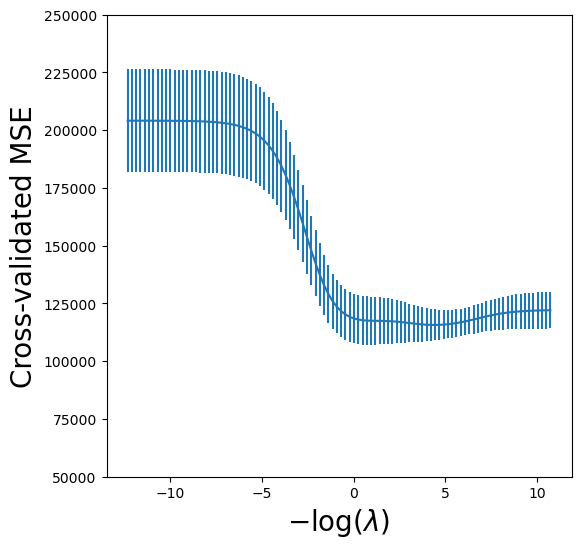

In [14]:
ridge_fig, ax = subplots(figsize = (6,6)) 
ax.errorbar(-np.log(lambdas), # add error bars
            -grid.cv_results_['mean_test_score'],
            yerr = grid.cv_results_['std_test_score'] / np.sqrt(K)
           ) 
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20) 
ax.set_ylabel('Cross-validated MSE', fontsize=20)

### Cross-Validation Pipeline

The ridge, lasso, and elastic net can be efficiently fit along a sequence of $\lambda$ values, creating what is known as a solution path. This can be easily performed within the pipeline without the need of using `GridSearchCV()`. Results may vary slightly because the standarization is performed on each fold individually, before fitting the model. 

In [15]:
ridgeCV = skl.ElasticNetCV(
    alphas = lambdas, 
    l1_ratio = 0,
    cv=kfold
)
pipeCV = Pipeline(steps = [('scaler', scaler), ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
       1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
       5.37495461e+03, 4.25955961e+03,...
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

Let's look at the cross-validation error:

Text(0, 0.5, 'Cross-validated MSE')

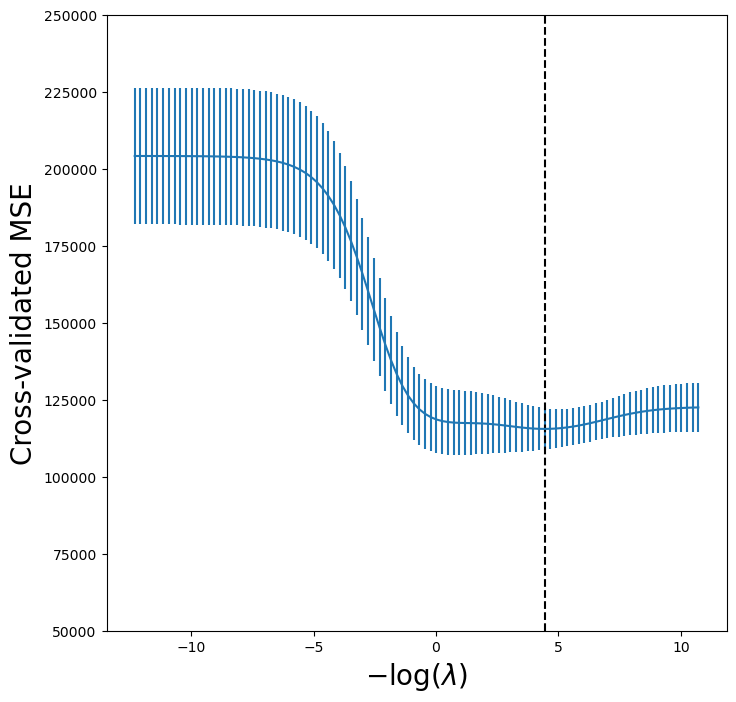

In [16]:
tuned_ridge = pipeCV.named_steps['ridge'] 
ridgeCV_fig, ax = subplots(figsize = (8,8)) 
ax.errorbar(
    -np.log(lambdas),
    tuned_ridge.mse_path_.mean(1),
    yerr = tuned_ridge.mse_path_.std(1) / np.sqrt(K)
) 
ax.axvline(-np.log(tuned_ridge.alpha_), c ='k', ls='--') # smallest cross-validation error
ax.set_ylim([50000, 250000]) 
ax.set_xlabel('$-\log(\lambda)$', fontsize = 20) 
ax.set_ylabel('Cross-validated MSE', fontsize = 20)

The plot is very similar to the one produced above. All the results of interest are stored in `tuned_ridge`, where `.alpha` attribute corresponds to the value of $\lambda$ that resulted in the smallest cross-validation error. The corresponding MSE is:

In [17]:
np.min(tuned_ridge.mse_path_.mean(1))

115526.70630987993

The corresponding coefficient estimates are:

In [18]:
tuned_ridge.coef_

array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
          3.64888723,  108.90953869,  -50.81896152, -105.15731984,
        122.00714801,   57.1859509 ,  210.35170348,  118.05683748,
       -150.21959435,   30.36634231,  -61.62459095,   77.73832472,
         40.07350744,  -25.02151514,  -13.68429544])

### The Lasso

The entire pipeline to fit Lasso is the same as for Ridge. The only difference is that we set `l1_ratio=1`.

In [19]:
lassoCV = skl.ElasticNetCV(
    alphas = lambdas, 
    l1_ratio = 1, 
    cv = kfold
)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso'] 
tuned_lasso.alpha_

3.1481221034523243

Let's do the same as before and plot the coefficients as $\lambda$ changes. Note how every coefficient is shrunken to exactly zero if the value of $\lambda$ is large enough. Hence, intermediate values of $\lambda$ can be used for feature selection.

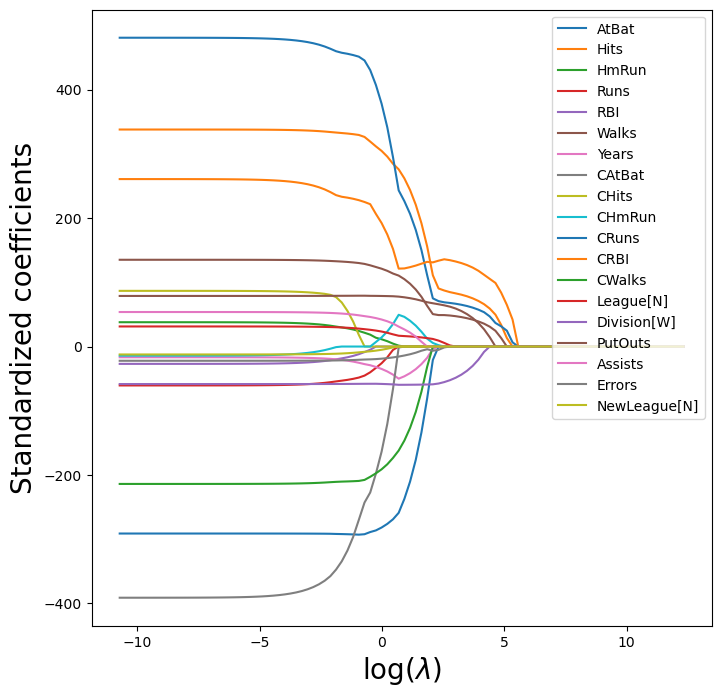

In [20]:
soln_array = skl.ElasticNet.path(Xs, Y, l1_ratio = 1, alphas=lambdas)[1]
soln_path = pd.DataFrame(soln_array.T, columns = D.columns, index = np.log(lambdas)) 
soln_path.index.name = 'log(lambda)'
path_fig, ax = subplots(figsize = (8,8)) 
soln_path.plot(ax = ax, legend = False) 
ax.set_xlabel('$\log(\lambda)$', fontsize = 20)
ax.set_ylabel('Standardized coefficients', fontsize = 20) 
ax.legend(loc = 'upper right')

Let’s again produce a plot of the cross-validation error.

Text(0, 0.5, 'Cross-validated MSE')

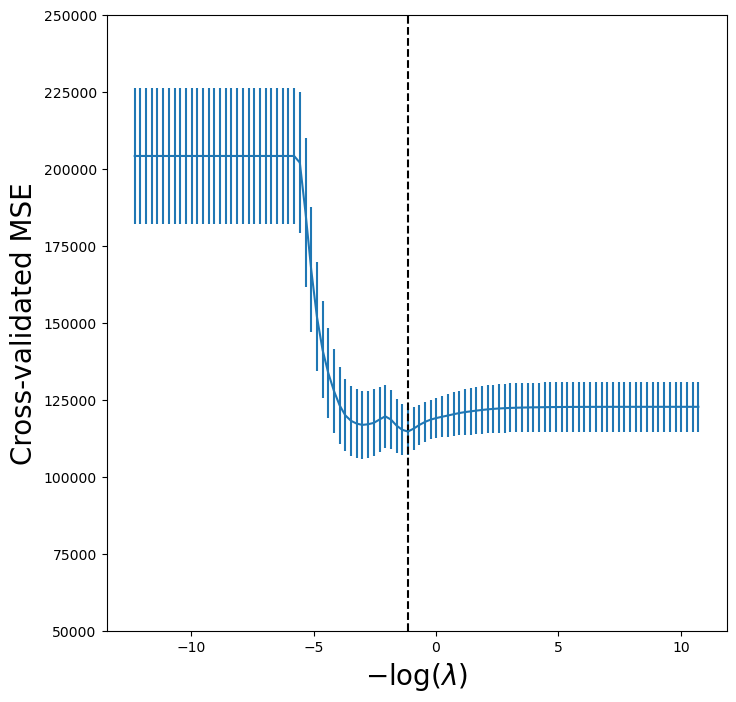

In [21]:
lassoCV_fig, ax = subplots(figsize=(8,8)) 
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K)) 
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--') 
ax.set_ylim([50000,250000]) 
ax.set_xlabel('$-\log(\lambda)$', fontsize=20) 
ax.set_ylabel('Cross-validated MSE', fontsize=20)

In [22]:
tuned_lasso.coef_

array([-209.97374999,  243.43053991,    0.        ,    0.        ,
          0.        ,   97.68430954,  -41.51608098,   -0.        ,
          0.        ,   39.6150143 ,  205.72600181,  124.55685811,
       -126.27309456,   15.70190319,  -59.50148285,   75.24404735,
         21.62024513,  -12.04162566,   -0.        ])

From the above output, we can see the variables that have been left out. There are 6 variables which coefficients have been set to zero. 